# Задание 1, 2, 3

Определим набор вспомогательных классов и функций:

*Remark: функции eval_output, f1_score и precision используют модифицированный код из eval.py. В частности в исходном скрипте при оценке игнорировался самый релевантный запросу документ.*

In [1]:
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import numpy as np
import string
import re
import math
import pickle


# primary language
_lang = "english"

# raw data sources
_doc_raw_file = "data/cran.all.1400"
_query_raw_file = "data/cran.qry"

# this applies only to _persistent_mode = True
_doc_db_file = "data/doc_db.dat"
_query_db_file = "data/query_db.dat"
_doc_index_file = "data/doc_index.dat"

_groundtruth_file = "data/qrel_clean"
# search results for evaluation
_answer_file = "data/train.qrel_clean"

# switch to turn on/off flushing data to disk
_persistent_mode = False


class TextAnalyzer(object):
    """docstring for TextAnalyzer"""
    def __init__(self, lang, stemmer = None, lemmatizer = None):
        super(TextAnalyzer, self).__init__()
        self.lang = lang
        self.stemmer = stemmer
        self.lemmatizer = lemmatizer
        self.stopwords = set(stopwords.words(lang))
        
    def tokenize(self, text):
        result = []
        for token in word_tokenize(text):
            token = token.lower().translate(None, string.punctuation)
            if not token or token in self.stopwords:
                continue
            if self.lemmatizer is not None:
                token = self.lemmatizer.lemmatize(token)
            if self.stemmer is not None:
                token = self.stemmer.stem(token)
            result.append(token)
        return result


class DataParser(object):
    """docstring for DataParser"""
    def __init__(self, pattern):
        super(DataParser, self).__init__()
        self.pattern = re.compile(pattern, re.S)
        
    def stream_data(self, path):
        with open(path) as fd:
            for result in self.pattern.findall(fd.read()):
                yield result


class Document(object):
    """docstring for Document"""
    def __init__(self, id_, title, abstract, meta = None):
        super(Document, self).__init__()
        self.id_ = id_
        self.title = title
        self.abstract = abstract
        self.meta = meta if meta is not None else dict()
        
    def __str__(self):
        return "id_={}\ntitle={}\nabstract={}\nmeta={}"\
                .format(str(self.id_), str(self.title), str(self.abstract), str(self.meta))


class Query(object):
    """docstring for Query"""
    def __init__(self, id_, body):
        super(Query, self).__init__()
        self.id_ = id_
        self.body = body
        
    def __str__(self):
        return "id_={}\nbody={}"\
                .format(str(self.id_), str(self.body))


class Database(object):
    """docstring for Database"""
    def __init__(self):
        super(Database, self).__init__()
        self.db = dict()
        
    def add(self, item_id, item):
        self.db[item_id] = item

    def find(self, item_id):
        return self.db.get(item_id, None)

    def stats_output(self):
        print "db size: {} item(s)".format(len(self.db))


class Posting(object):
    """docstring for Posting"""
    def __init__(self, id_, tf):
        super(Posting, self).__init__()
        self.id_ = id_
        self.tf = tf
        
    def __str__(self):
        return "id_={}\ntf={}"\
                .format(str(self.id_), str(self.tf))


class InvertedIndex(object):
    """docstring for InvertedIndex"""
    def __init__(self, text_analyzer):
        super(InvertedIndex, self).__init__()
        self.text_analyzer = text_analyzer
        self.index = dict()
        
    def add(self, item_id, item, index_field):
        content = getattr(item, index_field)
        tokens = self.text_analyzer.tokenize(content)
        tokens.sort()
        token = None
        tf = 0
        for i in xrange(len(tokens)):
            if token != tokens[i]:
                if token is not None:
                    if token not in self.index:
                        self.index[token] = []
                    self.index[token].append(Posting(item_id, tf))
                token = tokens[i]
                tf = 0
            tf += 1
            if i + 1 == len(tokens):
                if token not in self.index:
                    self.index[token] = []
                self.index[token].append(Posting(item_id, tf))
        return len(tokens)
        
    def find(self, token):
        return self.index.get(token, [])
    
    def stats_output(self):
        voc_len = len(self.index)
        aver_plen, max_plen, max_token = 0, 0, None
        for token, postings in self.index.iteritems():
            plen = len(postings)
            aver_plen += plen
            if max_plen < plen:
                max_plen = plen
                max_token = token
        aver_plen /= float(voc_len)
        print "vocabulary length: {}\npostings length (average): {}\npostings length (max): {} - \'{}\'"\
                .format(voc_len, aver_plen, max_plen, max_token)
            
    def __getstate__(self):
        state = self.__dict__.copy()
        del state["text_analyzer"]
        return state
    
    def __setstate__(self, state):
        self.__dict__.update(state)


class BM25Ranker(object):
    """docstring for BM25Ranker"""
    def __init__(self, k1, b, k2 = None):
        super(BM25Ranker, self).__init__()
        self.k1 = k1
        self.b = b
        self.k2 = k2
        
    def score(self, tfd, N, Nt, L, Ld, tfq = None):
        tfidf = self.idf(N, Nt) * self.tfd(tfd, L, Ld)
        if self.k2 is not None and tfq is not None:
            return tfidf * self.tfq(tfq)
        else:
            return tfidf
        
    def idf(self, N, Nt):
        return math.log(1 + ((N - Nt + 0.5) / (Nt + 0.5)))

    def tfd(self, tfd, L, Ld):
        return (tfd * (self.k1 + 1)) / (self.k1 * ((1 - self.b) + self.b * Ld / float(L)) + tfd)

    def tfq(self, tfq):
        return ((self.k2 + 1) * tfq) / float(self.k2 + tfq)


class BM25AltIDFRanker(BM25Ranker):
    """docstring for BM25AltIDFRanker"""
    def __init__(self, k1, b, k2 = None):
        super(BM25AltIDFRanker, self).__init__(k1, b, k2)

    def idf(self, N, Nt):
        return math.log(N / float(Nt))


class SearchEngine(object):
    """docstring for SearchEngine"""
    def __init__(self, text_analyzer, bm25_ranker, doc_index, doc_db):
        super(SearchEngine, self).__init__()
        self.text_analyzer = text_analyzer
        self.bm25_ranker = bm25_ranker
        self.doc_index = doc_index
        self.doc_db = doc_db
        # 
        self.N = len(self.doc_db.db)
        self.L = sum(doc.meta["tokenized_len"] for doc in self.doc_db.db.itervalues()) / float(self.N)
        
    def run_or_query(self, query, limit, normalize = False, threshold = None):
        query_index = InvertedIndex(self.text_analyzer)
        query_index.add(query.id_, query, "body")
        if len(query_index.index) == 0:
            return []
        if normalize:
            idf = dict()
        rsv = dict()
        for token in self.text_analyzer.tokenize(query.body):
            tfq = query_index.find(token)[0].tf
            postings = self.doc_index.find(token)
            for posting in postings:
                tfd = posting.tf
                Nt = len(postings)
                Ld = self.doc_db.find(posting.id_).meta["tokenized_len"]
                if normalize:
                    idf[posting.id_] = idf.get(posting.id_, 0) + self.bm25_ranker.idf(self.N, Nt)
                rsv[posting.id_] = rsv.get(posting.id_, 0) + self.bm25_ranker.score(tfd, self.N, Nt, self.L, Ld, tfq)
        
        if normalize:
            for doc_id, score in rsv.iteritems():
                rsv[doc_id] /= float(idf[doc_id])
        
        result = sorted(rsv.iteritems(), key = lambda e: e[1], reverse = True)[:limit]
        if threshold is not None:
            return [(doc_id, score) for doc_id, score in result if score >= threshold]
        else:
            return result


def objdump(obj, path):
    with open(path, "wb") as fd:
        pickle.dump(obj, fd, pickle.HIGHEST_PROTOCOL)


def objload(path):
    with open(path, "rb") as fd:
        return pickle.load(fd)


def parse_documents():
    doc_db = Database()
    doc_parser = DataParser("\.I\s(\d+)\n\.T\n(.*?)\.A.*?\.W\n(.*?)(?=(\.I|$))")
    for data in doc_parser.stream_data(_doc_raw_file):
        id_, title, abstract = int(data[0]), data[1], data[2]
        doc_db.add(id_, Document(id_, title, abstract))
    if _persistent_mode:
        objdump(doc_db, _doc_db_file)
    return doc_db


def parse_queries():
    query_db = Database()
    query_parser = DataParser("\.W\n(.*?)(?=(\.I|$))")
    id_ = 0
    for data in query_parser.stream_data(_query_raw_file):
        id_ += 1
        body = data[0]
        query_db.add(id_, Query(id_, body))
    if _persistent_mode:
        objdump(query_db, _query_db_file)
    return query_db


def index(text_analyzer, index_field, doc_db):
    doc_index = InvertedIndex(text_analyzer)
    for doc in doc_db.db.itervalues():
        doc.meta["tokenized_len"] = doc_index.add(doc.id_, doc, index_field)
    if _persistent_mode:
        objdump(doc_index, _doc_index_file)
        objdump(doc_db, _doc_db_file)
    return doc_index


def search(text_analyzer, ranker, doc_index, doc_db, query_db, limit, normalize = False, threshold = None):    
    engine = SearchEngine(text_analyzer, ranker, doc_index, doc_db)
    with open(_answer_file, "w") as fd:
        for query in query_db.db.itervalues():
            docset = engine.run_or_query(query, limit, normalize, threshold)
            for doc in docset:
                fd.write(str(query.id_) + " " + str(doc[0]) + "\n")


def eval_output():
    q2reld = {} 
    for line in open(_groundtruth_file):
        qid, did = [int(x) for x in line.split()]
        if qid not in q2reld:
            q2reld[qid] = set()
        q2reld[qid].add(did)
    # 
    q2retrd = {}
    for line in open(_answer_file):
        qid, did = [int(x) for x in line.split()]
        if qid not in q2retrd:
            q2retrd[qid] = []
        q2retrd[qid].append(did)
    if not q2retrd:
        print("mean precision: {}\nmean recall: {}\nmean F-measure: {}")
        print("MAP@10: {}")
        return
    # 
    N = len(q2retrd.keys())
    precision = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2retrd[q]) for q in q2retrd.keys()]) / N
    recall = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2reld[q]) for q in q2retrd.keys()]) / N
    print("mean precision: {}\nmean recall: {}\nmean F-measure: {}"\
          .format(precision, recall, 2*precision*recall/(precision+recall)))
    # MAP@10
    MAP = 0.0
    for q in q2retrd.keys():
        n_results = min(10, len(q2retrd[q]))
        avep = np.zeros(n_results)
        for i in range(n_results):
            avep[i:] += q2retrd[q][i] in q2reld[q]
            avep[i] *= (q2retrd[q][i] in q2reld[q]) / (i+1.0)
        MAP += sum(avep) / min(n_results, len(q2reld[q]))
    print("MAP@10: {}".format(MAP/N))


def f1_score():
    q2reld = {} 
    for line in open(_groundtruth_file):
        qid, did = [int(x) for x in line.split()]        
        if qid not in q2reld:
            q2reld[qid] = set()
        q2reld[qid].add(did)

    # 
    q2retrd = {}
    for line in open(_answer_file):
        qid, did = [int(x) for x in line.split()]
        if qid not in q2retrd:
            q2retrd[qid] = []
        q2retrd[qid].append(did)
    if not q2retrd:
        return 0.0
    # 
    N = len(q2retrd.keys())
    precision = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2retrd[q]) for q in q2retrd.keys()]) / N
    recall = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2reld[q]) for q in q2retrd.keys()]) / N
    return 2*precision*recall/(precision+recall)

def precision():
    q2reld = {} 
    for line in open(_groundtruth_file):
        qid, did = [int(x) for x in line.split()]
        if qid not in q2reld:
            q2reld[qid] = set()
        q2reld[qid].add(did)
    # 
    q2retrd = {}
    for line in open(_answer_file):
        qid, did = [int(x) for x in line.split()]
        if qid not in q2retrd:
            q2retrd[qid] = []
        q2retrd[qid].append(did)
    if not q2retrd:
        return 0.0
    # 
    N = len(q2retrd.keys())
    precision = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2retrd[q]) for q in q2retrd.keys()]) / N
    return precision


# Задание 4, 5

Распарсим данные о статьях и запросы:

In [2]:
# _persistent_mode = True

print "------doc_db------"
_doc_db = parse_documents()
_doc_db.stats_output()

print "\n------query_db------"
_query_db = parse_queries()
_query_db.stats_output()


------doc_db------
db size: 1400 item(s)

------query_db------
db size: 225 item(s)


Определим при каком способе нормализации и выборе индексируемого поля мы получим наилучшее качество поиска:

In [3]:
def task45(index_field):
    print "\n------index_field = \'{}\'------".format(index_field)
    text_analyzers = [TextAnalyzer(_lang), \
                  TextAnalyzer(_lang, stemmer = SnowballStemmer(_lang)), \
                  TextAnalyzer(_lang, lemmatizer = WordNetLemmatizer()), \
                  TextAnalyzer(_lang, stemmer = SnowballStemmer(_lang), lemmatizer = WordNetLemmatizer())]
    ranker = BM25Ranker(1.2, 0.75)
    for i in xrange(len(text_analyzers)):
        print "\ntext_analyzer idx = {}:".format(i)
        doc_index = index(text_analyzers[i], index_field, _doc_db)
        print "---INDEX STATS---"
        doc_index.stats_output()
        search(text_analyzers[i], ranker, doc_index, _doc_db, _query_db, 10)
        print "---SEARCH STATS---"
        eval_output()

task45("title")
task45("abstract")



------index_field = 'title'------

text_analyzer idx = 0:
---INDEX STATS---
vocabulary length: 1914
postings length (average): 5.65987460815
postings length (max): 319 - 'flow'
---SEARCH STATS---
mean precision: 0.224888888889
mean recall: 0.330929412138
mean F-measure: 0.267793801171
MAP@10: 0.255775316341

text_analyzer idx = 1:
---INDEX STATS---
vocabulary length: 1479
postings length (average): 7.30696416498
postings length (max): 359 - 'flow'
---SEARCH STATS---
mean precision: 0.246666666667
mean recall: 0.361286927292
mean F-measure: 0.293171857033
MAP@10: 0.28750920467

text_analyzer idx = 2:
---INDEX STATS---
vocabulary length: 1718
postings length (average): 6.29511059371
postings length (max): 359 - 'flow'
---SEARCH STATS---
mean precision: 0.238666666667
mean recall: 0.35039711472
mean F-measure: 0.283935675634
MAP@10: 0.276800512304

text_analyzer idx = 3:
---INDEX STATS---
vocabulary length: 1477
postings length (average): 7.31685849695
postings length (max): 359 - 'flow'

В выводе выше, помимо усредненных оценок качества по выдачам, представлены также статистики по индексам, построенным для разных нормализаторов. 

Из полученных результатов следует, что качество поиска улучшается при индексации по более длинному полю - *abstract*. Это объясняется ростом вероятности встретить терм из запроса в документе с увеличением размера последнего. Лучшие результаты удалось получить на трех нормализаторах: 'только стемминг', 'только лемматизация', 'стемминг и лемматизация'. При этом все три результата различаются несущественно. Далее будем использовать нормализатор, использующий исключительно лемматизатор.

In [4]:
_text_analyzer = TextAnalyzer(_lang, lemmatizer = WordNetLemmatizer())
_index_field = "abstract"

# Задание 6

Попробуем оптимизировать параметры k1 и b функции BM25. Для этого запустим поиск в каждом узле сетки k1xb=(1.2,2)x(0,1) и сравним качество ответов, используя усредненную F-меру. Проведем два испытания: в первом будем индексировать по полю *title*, а во втором - по *abstract*:

In [5]:
def task6(index_field):
    print "\n------index_field = \'{}\'------".format(index_field)
    doc_index = index(_text_analyzer, index_field, _doc_db)
    
    _f1, _k1, _b = None, None, None 
    for k1 in np.arange(1.2, 2, 0.1):
        for b in np.arange(0, 1, 0.1):
            ranker = BM25Ranker(k1, b)
            search(_text_analyzer, ranker, doc_index, _doc_db, _query_db, 10)
            f1 = f1_score()
            if _f1 is None or _f1 < f1:
                _f1 = f1
                _k1 = k1
                _b = b
                
    print("k1: {}\nb: {}\nF-measure: {}".format(_k1, _b, _f1))

task6("title")
task6("abstract")



------index_field = 'title'------
k1: 1.3
b: 0.8
F-measure: 0.285328152135

------index_field = 'abstract'------
k1: 1.9
b: 0.5
F-measure: 0.352592558251


k1 характеризует насколько большой будет разница в релевантности между документом с минимальной и документом с максимальной частотой встречаемости терма. Понятно, что в тексте большей длины будет большая вариативность частот встречаемости термов. Поэтому для 'abstract' лучшее качество ответа мы получили при более высоком значении k1, чем для 'title'.

b характеризует то, насколько длина документа влияет на степень его релевантности. Очевидно, что для поля 'abstract' учет фактора длины не играет столь существенной роли, как для поля 'title'. 

In [6]:
_k1 = 1.9
_b = 0.5

# Задание 7 

Заменим в функции BM25 IDF-составляющую на $log(\frac{N}{Nt})$. Оценим качество поиска при использовании модифицированной BM25 формулы:

In [7]:
def task7(ranker):
    doc_index = index(_text_analyzer, _index_field, _doc_db)
    search(_text_analyzer, ranker, doc_index, _doc_db, _query_db, 10)
    eval_output()
    
print "------BM25Ranker------"
task7(BM25Ranker(_k1, _b))
print "\n------BM25AltIDFRanker------"
task7(BM25AltIDFRanker(_k1, _b))


------BM25Ranker------
mean precision: 0.298666666667
mean recall: 0.43028238359
mean F-measure: 0.352592558251
MAP@10: 0.360366316033

------BM25AltIDFRanker------
mean precision: 0.299111111111
mean recall: 0.430837939145
mean F-measure: 0.353088793365
MAP@10: 0.360716404216


Из результатов выше следует, что при замене формулы качество поиска существенно не изменилось.

# Задание 8 

Попробуем провести нормализацию RSV величин для документов в процессе поиска:

In [8]:
def task8(normalize):
    doc_index = index(_text_analyzer, _index_field, _doc_db)
    ranker = BM25Ranker(_k1, _b)
    search(_text_analyzer, ranker, doc_index, _doc_db, _query_db, 10, normalize)
    eval_output()
    
print "------Normalize=False------"
task8(False)
print "\n------Normalize=True------"
task8(True)


------Normalize=False------
mean precision: 0.298666666667
mean recall: 0.43028238359
mean F-measure: 0.352592558251
MAP@10: 0.360366316033

------Normalize=True------
mean precision: 0.0231111111111
mean recall: 0.0285820823102
mean F-measure: 0.0255570854241
MAP@10: 0.0139635900451


Из полученных результатов следует, что качество поиска существенно снизилось после нормализации. 

# Задание 9

Добавим в функцию BM25 множитель, отвечающий за частоту встречаемости термов в запросе: 

In [9]:
def task9():
    print "\n------index_field = \'{}\'------".format(_index_field)
    doc_index = index(_text_analyzer, _index_field, _doc_db)
    _k2, _f1 = None, None
    for k2 in [0, 25, 50, 75, 100, 250, 500, 750, 1000]:
        ranker = BM25Ranker(_k1, _b, k2)
        search(_text_analyzer, ranker, doc_index, _doc_db, _query_db, 10)
        f1 = f1_score()
        if _f1 is None or _f1 < f1:
            _f1 = f1
            _k2 = k2
    print("k2: {}\nF-measure: {}".format(_k2, _f1))
    
task9()



------index_field = 'abstract'------
k2: 0
F-measure: 0.352592558251


Для ранее найденных лучших значений k1 и b мы получили для k2 лучшую оценку равную 0. Это говорит о том, что влияние частоты встречаемости термов в запросе на качество выдачи минимально. Скорее всего, это связано с тем, что в предложенных запросах термы повторялись не так часто.

In [10]:
_k2 = 0

# Задание 10 

Определим зависимость точности выдачи от заданной величины порога для RSV документа.

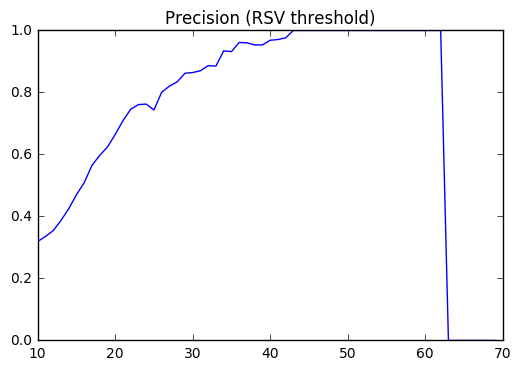

In [11]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def task10():
    doc_index = index(_text_analyzer, _index_field, _doc_db)
    ranker = BM25Ranker(_k1, _b, _k2)
    xpts, ypts = [], []
    for threshold in xrange(10, 70):
        search(_text_analyzer, ranker, doc_index, _doc_db, _query_db, 10, False, threshold)
        xpts.append(threshold)
        ypts.append(precision())

    f, ax = plt.subplots()
    ax.plot(xpts, ypts)
    ax.set_title('Precision (RSV threshold)')
    plt.show()
    
task10()


Из графика заметно, что полученная зависимость имеет логарифмический характер. Нули в конце означают, что в ответ на запрос была получена пустая выдача, т.е. не нашлось документа с RSV, превосходящим пороговое значение.